# Problem 2: Multi-objective optimization with NSGA-II
## Alexander Belov

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import numpy as np
from itertools import product

rng = np.random.default_rng(seed=1)

$$
f_1(x) = 1 - \exp \left( -\sum_{i=1}^{n} \left(x_i - \frac{1}{\sqrt{n}} \right)^2 \right)
$$
$$
f_2(x) = 1 - \exp \left( -\sum_{i=1}^{n} \left(x_i - \frac{1}{\sqrt{n}} \right)^2 \right)
$$

$$
(f_1, f_2) \rightarrow \min_x
$$

$$
x_i \in [-4,4]
$$

$$
n = 3
$$

In [2]:
def f(pop):
    n = pop.shape[1]
    assert n == 3
    z1 = (pop - 1/np.sqrt(n))**2
    f1 = 1 - np.exp(-np.sum(z1, axis=1))
    z2 = (pop + 1/np.sqrt(n))**2
    f2 = 1 - np.exp(-np.sum(z2, axis=1))
    res = -np.vstack([f1, f2]).T # "-" because we want minimization, but my NSGA code assumes maximization
    assert res.shape == (pop.shape[0], 2), (res.shape, pop.shape)
    return res

Children are produced by adding normally distributed noise to each parent and clipping the result.

In [3]:
def gen_children(pop, fpop):
    children = []
    npop = len(pop)
    for i in range(npop):
        ch = pop[i] + rng.normal(size=pop[i].shape, scale=0.1) # mutation
        ch = np.clip(ch, -4, 4) # repair
        children.append(ch)
    return np.array(children)

NSGA-II subroutines.

In [4]:
def dominates(i1, i2, fpop):
    return np.all(fpop[i1] >= fpop[i2]) and np.any(fpop[i1] > fpop[i2])


def fast_non_dominated_sort(fpop):
    npop = fpop.shape[0]

    n_p = np.zeros(npop, dtype=int)
    s = np.zeros((npop,npop), dtype=bool)

    for i, j in product(range(npop), repeat=2):
        if dominates(i, j, fpop):
            n_p[j] += 1
            s[i,j] = 1

    # fronts[i] = nondom. front to which pop[i] belongs
    fronts = np.empty(npop, dtype=int) 

    cur_front = 0
    n_visited = 0
    visited = [False] * npop
    while n_visited != npop:
        cur_front_list = []
        for i in range(npop):
            if (not visited[i]) and (n_p[i] == 0):
                fronts[i] = cur_front
                cur_front_list.append(i)
                visited[i] = True
                n_visited += 1
        for i in cur_front_list:
            n_p[s[i] == True] -= 1
        cur_front += 1

    return cur_front, fronts


def crowding_distance_assignment(fpop):
    npop, nobjs = fpop.shape

    if npop == 1:
        return np.array([np.inf])

    dists = np.zeros(npop)
    for i_obj in range(nobjs):
        idx = np.argsort(fpop[:, i_obj]) # sort front wrt i_obj-th objective
        fobj_min = np.min(fpop[:, i_obj])
        fobj_max = np.max(fpop[:, i_obj])

        dists[idx[0]] = np.inf
        dists[idx[-1]] = np.inf

        for i in range(1, npop - 1):
            if not np.isinf(dists[idx[i]]): # skip boundary points
                dists[idx[i]] += (fpop[idx[i+1], i_obj] - fpop[idx[i-1], i_obj]) / (fobj_max - fobj_min)

    return dists

Main loop.

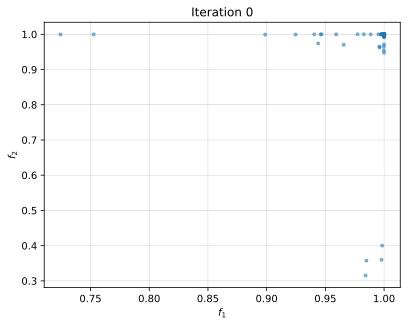

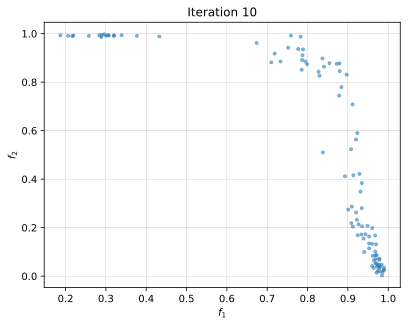

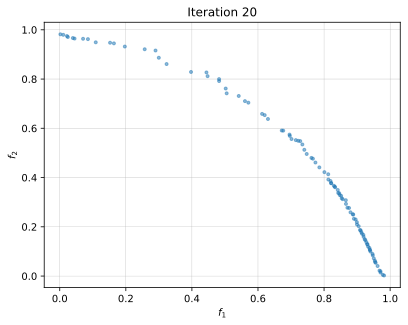

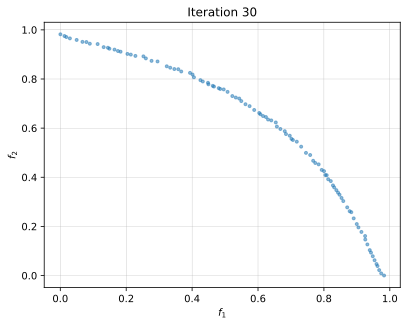

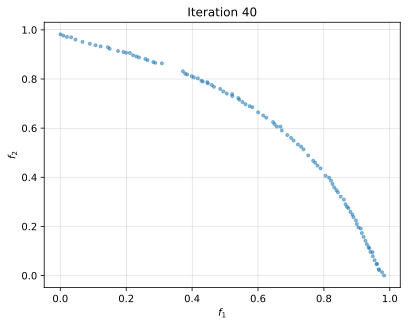

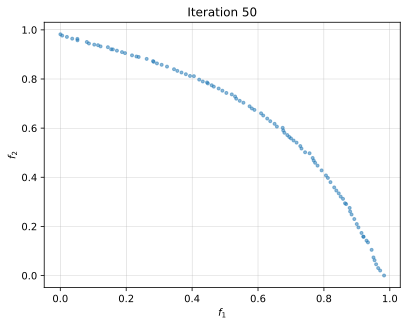

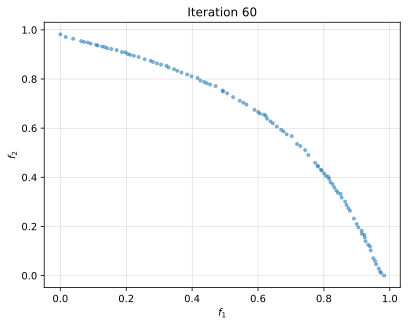

In [5]:
# create parent population (P0 in the paper)
npop = 100
pop = rng.uniform(low=-4, high=4, size=(npop, 3))
fpop = f(pop)

# main NSGA-II loop
n_iters = 61
for it in range(n_iters):

    # create a new population Q
    children = gen_children(pop, fpop)
    fchildren = f(children)

    # combine parent and offspring population
    # comb_pop is called Rt in the paper
    comb_pop = np.vstack([pop, children])
    comb_fpop = np.vstack([fpop, fchildren])

    # all nondominated fronts of Rt (corresponds to F in the paper)
    n_fronts, fronts = fast_non_dominated_sort(comb_fpop) 

    # calc all crowd_dists
    crowd_dists = np.empty(comb_fpop.shape[0])
    for i_front in range(n_fronts):
        # calculate crowding-distance in i_front-th front
        # comb_fpop[fronts == i_front] is called Fi in the paper
        front_crowd_dists = crowding_distance_assignment(comb_fpop[fronts == i_front])
        crowd_dists[fronts == i_front] = front_crowd_dists

    # sort in desc order using <_n (the crowded-comparison operator, hence "cco")
    cco_keys = np.vstack([-crowd_dists, fronts])
    cco_sort_idx = np.lexsort(cco_keys)

    # choose top npop elements...
    pop = comb_pop[cco_sort_idx[:npop]]
    fpop = comb_fpop[cco_sort_idx[:npop]]

    if it % 10 == 0:
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(-fpop[:,0], -fpop[:,1], marker='.', alpha=0.5)
        ax.set_xlabel('$f_1$')
        ax.set_ylabel('$f_2$')
        ax.grid('on', linewidth=0.3)
        ax.set_title(f'Iteration {it}')
        ax.set_axisbelow(True)
        plt.show()
